#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [2]:
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

In [3]:
try: 
    taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
taxi.sort_index(inplace=True)
print(taxi.index.is_monotonic)

True


In [8]:
taxi = taxi.resample('1H').sum()

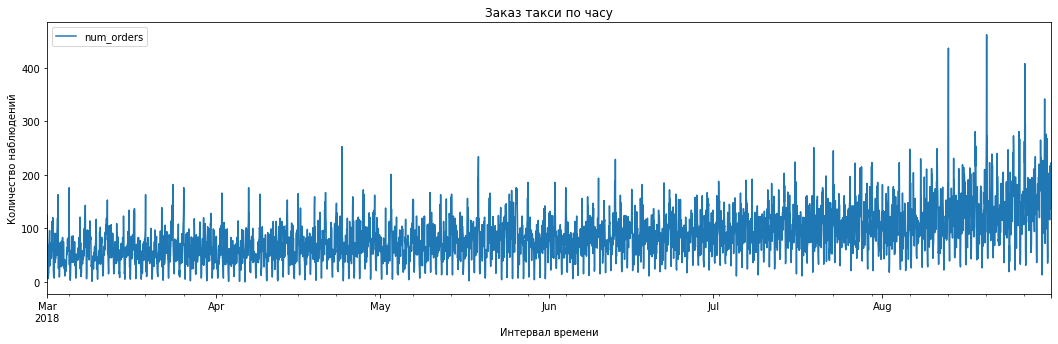

In [9]:
taxi.plot(figsize=(18,5))
plt.title('Заказ такси по часу');
plt.xlabel('Интервал времени');
plt.ylabel('Количество наблюдений')
plt.show()

Прежде всего я загрузила данные, посмотрела информацию по данным, изменила тип данных Datetime с object на datetime64 и установила индекс таблицы равным столбцу Datetime. Также убедилась, что дата и время становлены в хронологическом порядке. Нам дан период с 1го марта 2018 г до 31 августа 2018 г. В изначальных данных был дал интервал 10 минут, поменяли интервал на 1 час

## Анализ

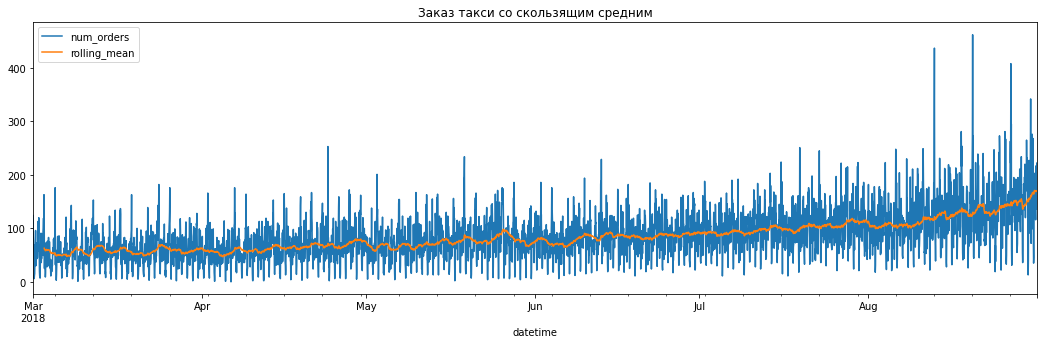

In [10]:
taxi['rolling_mean'] = taxi.rolling(50).mean() 
taxi.plot(figsize=(18,5))
plt.title('Заказ такси со скользящим средним')
plt.show()

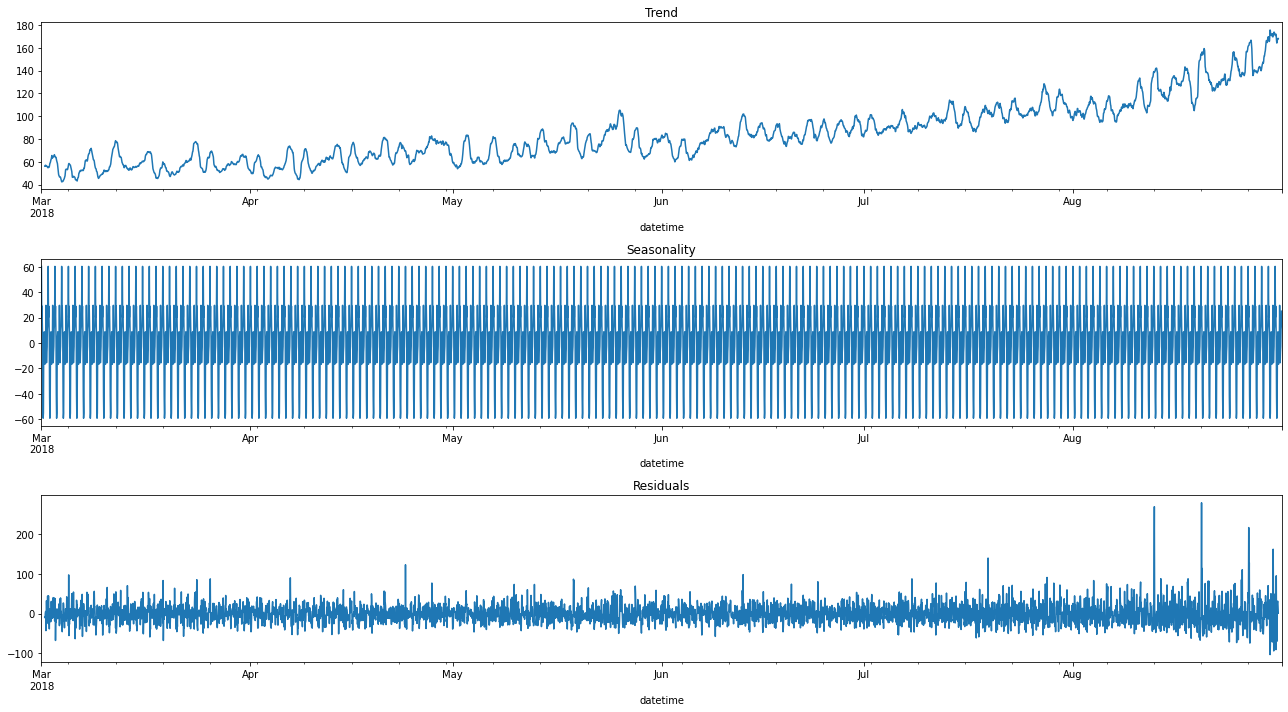

In [11]:
decomposed = seasonal_decompose(taxi.drop('rolling_mean', axis=1)) 
plt.figure(figsize=(18,10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

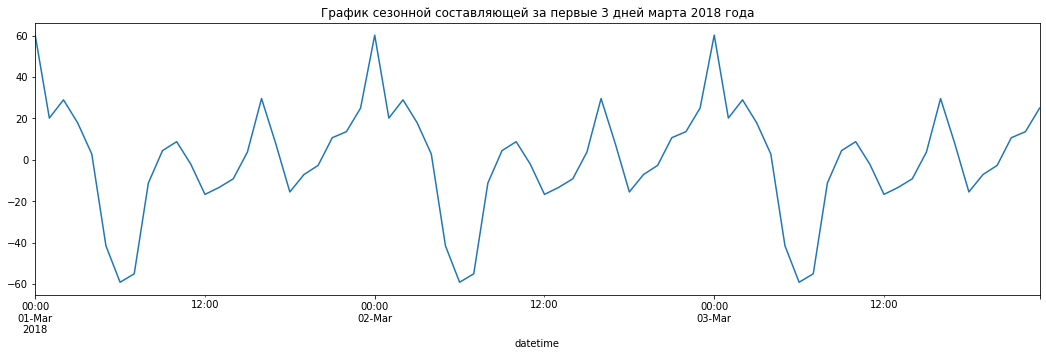

In [12]:
plt.figure(figsize=(18,5))
decomposed.seasonal['2018-03-01': '2018-03-03'].plot(ax=plt.gca())
plt.title('График сезонной составляющей за первые 3 дней марта 2018 года')
plt.show()

В результате анализа данных заметен тренд на увеличение заказов каждый меяц, начиная с марта, пик заказов приходится на август. Учитывая это, можно предположить, что количество заказов будет продолжать увеличиваться. Так же на примере первых 3 дней марта заметна повторяющаяся динамика. Пик заказов приходится на вечернее и ночное время, минимальное количество заказов в 6 утра.

## Обучение

In [13]:
def make_features(taxi, max_lag, rolling_mean_size): 
    taxi['day'] = taxi.index.day
    taxi['dayofweek'] = taxi.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)

    taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(taxi, 48, 7)

In [14]:
taxi.head()

,num_orders,rolling_mean,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
taxi.shape

(4416, 52)

In [16]:
train, valid=train_test_split(taxi, test_size=0.2, shuffle=False) 
valid, test=train_test_split(valid, test_size=0.5, shuffle=False) 
print(train.shape)
print(valid.shape)
print(test.shape)

(3532, 52)
(442, 52)
(442, 52)


In [17]:
train = train.dropna() 

In [18]:
valid = valid.dropna() 

In [19]:
features_train  = train.drop('num_orders', axis=1) 
target_train = train[['num_orders']]
features_valid  = valid.drop('num_orders', axis=1)
target_valid = valid[['num_orders']]
features_test = test.drop('num_orders', axis=1)
target_test = test[['num_orders']]

In [20]:
model_lin = LinearRegression() 
model_lin= model_lin.fit(features_train, target_train)
predictions = model_lin.predict(features_valid)
model_lin_score=(mean_squared_error(target_valid, predictions))**0.5
print('RMSE для линейной регрессии:', model_lin_score.round(2))

RMSE для линейной регрессии: 31.65


In [21]:
model_tree=DecisionTreeRegressor() 
parameters={'max_depth': np.arange(1,40),
           'max_features': [x for x in range(1,11)]
           }
tscv = TimeSeriesSplit(n_splits=10)
model_tree_g= GridSearchCV(estimator=model_tree,
                           cv=tscv,
                           param_grid=parameters,
                           scoring='neg_mean_squared_error',
                        )
model_tree_g.fit(features_train, target_train)
predictions_valid=model_tree_g.predict(features_valid)
model_tree_g_score=(mean_squared_error(target_valid, predictions_valid))**0.5
print('Лучшие гиперпараметры для дерева: ', model_tree_g.best_params_)
print('RMSE для дерева:', model_tree_g_score.round(2))

Лучшие гиперпараметры для дерева:  {'max_depth': 5, 'max_features': 8}
RMSE для дерева: 43.27


In [22]:
model_LGBM=LGBMRegressor() 
parameters={'n_estimators' : [50, 100],
            'max_depth' : [5, 7, 10]
            }
tscv = TimeSeriesSplit(n_splits=10)
model_LGBM= GridSearchCV(model_LGBM,
                        cv=tscv,
                        param_grid=parameters,
                        scoring='neg_mean_squared_error',
                        n_jobs=-1,
                        verbose=10
                        )
model_LGBM.fit(features_train, target_train)
predictions_valid=model_LGBM.predict(features_valid)
model_LGBM_score=(mean_squared_error(target_valid, predictions_valid))**0.5
print('Лучшие гиперпараметры для LightGBM: ', model_LGBM.best_params_)
print('RMSE для LightGBM:', model_LGBM_score.round(2))

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV 1/10; 1/6] START max_depth=5, n_estimators=50...............................
[CV 1/10; 1/6] END .............max_depth=5, n_estimators=50; total time=   0.5s
[CV 2/10; 1/6] START max_depth=5, n_estimators=50...............................
[CV 2/10; 1/6] END .............max_depth=5, n_estimators=50; total time=   0.4s
[CV 3/10; 1/6] START max_depth=5, n_estimators=50...............................
[CV 3/10; 1/6] END .............max_depth=5, n_estimators=50; total time=   0.3s
[CV 4/10; 1/6] START max_depth=5, n_estimators=50...............................
[CV 4/10; 1/6] END .............max_depth=5, n_estimators=50; total time=   0.5s
[CV 5/10; 1/6] START max_depth=5, n_estimators=50...............................
[CV 5/10; 1/6] END .............max_depth=5, n_estimators=50; total time=   0.5s
[CV 6/10; 1/6] START max_depth=5, n_estimators=50...............................
[CV 6/10; 1/6] END .............max_depth=5, n_e

Я обучила три модели линейную регрессию, дерево решений и LightGBM. Лучшая RMSE у LightGBM 32.52. Посмотрим, что покажет тестирование

## Тестирование

In [23]:
model_test_lin = LinearRegression()
model_test_lin.fit(features_train, target_train)
predicted_test_lin= model_test_lin.predict(features_test)
model_test_score=(mean_squared_error(target_test, predicted_test_lin))**0.5
print('RMSE для тестовой модели линейной регрессии:', model_test_score.round(2))

RMSE для тестовой модели линейной регрессии: 42.17


In [24]:
result = {
    'Model' : ['LinearRegression', 'DecisionTreeRegressor', 'LGBMRegressor'],
    'Valid RMSE' :pd.Series([31.65, 38.47, 31.67]),
    'Test RMSE' :pd.Series([ 42.17, 0, 0]),
    }
display(pd.DataFrame(result))

,Model,Valid RMSE,Test RMSE
0,LinearRegression,31.65,42.17
1,DecisionTreeRegressor,38.47,0.00
2,LGBMRegressor,31.67,0.00


**ВЫВОД** В процессе работы я изучила данные, ресмплировала временной ряд по часуб проверила временной ряд на тренды и сезонность.
Обучила модели линейной регрессии, дерева решений и LGBMRegressor. Проверили модели с лучшими гиперпараметрами на тестовой выборке. Проверка показала, что лишь одна модель уложилась в значение RMSE 48, а именно получилось 46,11. У остальных воделей показатели выше. Данную модель и буду рекомендоватьиспользовать для прогнозирования количество заказов такси на следующий час.